# Wstęp do Sztucznej Inteligencji - rok akademicki 2021/2022

Przed rozpoczęciem pracy z notatnikiem zmień jego nazwę zgodnie z wzorem: `NrAlbumu_Nazwisko_Imie_PoprzedniaNazwa`.

Przed wysłaniem notatnika upewnij się, że rozwiązałeś wszystkie zadania/ćwiczenia.

# Temat: Wnioskowanie oparte na wiedzy niepewnej. Wnioskowanie bayesowskie
Zapoznaj się z treścią niniejszego notatnika czytając i wykonując go komórka po komórce. Wykonaj napotkane zadania/ćwiczenia.

Na niniejszych laboratoriach będziemy wykorzystywać bibliotekę `pymc3` (https://docs.pymc.io/). Biblioteka ta jest już zainstalowana w środowisku.

__Zgodnie z komunikatem, który się pojawił uruchom ponownie środowisko wykonawcze.__

In [1]:
import pymc3 as pm
import arviz as az
import numpy as np
print('Pymc3 version:', pm.__version__)
print('Arviz version:', az.__version__)
print('Numpy version:', np.__version__)

Pymc3 version: 3.11.4
Arviz version: 0.11.4
Numpy version: 1.21.5


## Wnioskowanie probabilistyczne
Wnioskowanie probabilistyczne nazywamy także wnioskowaniem bayesowskim, ze względu na kluczową rolę, jaką w nim pełni wzór Bayesa. Jest to metoda przetwarzania wiedzy niepewnej oparta na bezpośrednim wykorzystaniu rachunku prawdopodobieństwa, w której poszczególnym stwierdzeniom przypisuje się prawdopodobieństwo ich prawdziwości.

### Wzór na prawdopodobieństwo warunkowe:

$$ P(A|B) = \frac{P(A\cap B)}{P(B)} \stackrel{z}{=}\frac{P(A)P(B)}{P(B)},$$
gdzie równość $\stackrel{z}{=}$ zachodzi przy założeniu niezależności zdarzeń $A$ i $B$.

### Wzór Bayesa: 
Opisuje następującą zależność prawdopodobieństw warunkowych:

$$ P(A|B)=\frac{P(B|A)P(A)}{P(B)}.$$

### Prawdopodobieństwo całkowite:
Jeżeli zdarzenia $B_1,B_2,\ldots,B_n$ są parami rozłączne oraz mają prawdopodobieństwa dodatnie, które sumują się do jedynki, to dla dowolnego zdarzenia $A$ zachodzi wzór:

$$P(A)=P(A|B_1)P(B_1)+P(A|B_2)P(B_2)+\ldots +P(A|B_n)P(B_n).$$

### Zastosowanie we wnioskowaniu:
Załóżmy, że bierzemy pod uwagę skończoną liczbę hipotez $H_1,\ldots,H_n$ parami niezależnych i wyczerpujących wszystkie możliwości. Oraz dysponujemy skończoną liczbą przesłanek $E_1,\ldots,E_m$, o których wiemy, że zaszły. Wówczas z wzoru Bayesa przez zastosowanie wzoru na prawdopodobieństwo całkowite można wyprowadzić następujący wzór ogólny:

$$P(H_i|E_1,\ldots,E_m)=\frac{P(E_1,\ldots, E_m|H_i)P(H_i)}{\sum\limits_{j=0}^nP(E_1,\ldots,E_m|H_j)P(H_j)}.$$

Oznacza to, że znając prawdopodobieństwa a priori hipotez $P(H_i)$ oraz prawdopodobieństwa warunkowe $P(E_j|H_i)$ możemy wyznaczyć prawdopodobieństwa a posteriori hipotez $P(H_i|E_j)$.

## Naiwny model Bayesa
Ostatnie zdanie poprzedniego punktu można przyjąć jedynie z pewnym zastrzeżeniem. $P(A \cap B) = P(A)P(B)$ wtedy i tylko wtedy jeśli $A$ oraz $B$ są niezależne. Zależność ta jest również prawdziwa warunkowo, tzn. $P(A \cap B|C) = P(A|C)P(B|C)$ dla pewnego zdarzenia $C$, wtedy i tylko wtedy jeśli $A$ oraz $B$ są niezależne pod warunkiem $C$. 

Zatem, w ogólnym przypadku oryginalny wzór Bayesa

$$P(H_i|E_1,\ldots,E_m)=\frac{P(E_1,\ldots, E_m|H_i)P(H_i)}{\sum\limits_{j=0}^nP(E_1,\ldots,E_m|H_j)P(H_j)}.$$

nie jest równoważny

$$P(H_i|E_1,\ldots,E_m)=\frac{P(E_1|H_i)P(E_2|H_i)\ldots P(E_m|H_i)P(H_i)}{\sum\limits_{j=0}^nP(E_1|H_j)P(E_2|H_j)\ldots P(E_m|H_j)P(H_j)}.$$

Są one równoważne jedynie jeśli przesłanki $E$ są niezależne pod warunkiem każdej $H_i$. 

Drugi wzór jest jednak o wiele korzystniejszy w praktyce, jako iż łatwiej jest estymować prawdopodobieństwa dla pojedynczych $E$ niż rozkłady łączne dla $E_1,\ldots,E_m$. Jeśli stosujemy drugi wzór mimo braku niezależności $E$, mamy do czynienia z pewną naiwnością - naiwnym liczeniem na to, iż mimo naruszenia ścisłego matematycznego wymogu niezależności, model i tak będzie działał. I tak też często jest. Jakość działania takiego naiwnego modelu zależy m.in. od tego, jak bardzo odbiegamy od ideału całkowitej niezależności $E$.

__Uwaga__: We wszystkich poniższych przykładach, zwróć uwagę, kiedy korzystamy z tego założenia.

### Skąd prawdopodobieństwa?
Zarówno prawdopodobieństwa a priori jak i warunkowe, potrzebne do zastosowania wzoru Bayesa, można otrzymać od ekspertów bądź też szacować na podstawie danych historycznych.

## Przykład 1: Test medyczny

- Pewna choroba $X$ dotyczy $1\%$ populacji.
- Test wykrywa chorobę ze skutecznością $99\%$ (ang. recall, czułość testu, czyli jego zdolność wykrycia choroby pod warunkiem, że dana osoba rzeczywiście jest chora).
- Test błędnie wykrywa chorobę w przypadku $2\%$ zdrowych ludzi (ang. false alarm rate, $FAR$, przypadek fałszywie pozytywny; specyficzność testu jest pojęciem pokrewnym, jest to zdolność testu wskazania braku choroby dla osoby rzeczywiście zdrowej, czyli specyficzność = $1 - FAR$).
- Po wykonaniu testu, Pan $Z$ dostaje wynik pozytywny. 

__Jakie jest prawdopodobieństwo, że Pan $Z$ jest chory?__

Należy skorzystać ze wzoru Bayesa.

$H$ - Pan $Z$ jest chory

$E$ - wynik testu jest pozytywny

$P(H|E)$ - to chcemy policzyć

$P(H)$ = 0.01, zatem $P(\neg H)$ = 0.99

$P(E|H)$ = 0.99

$P(E|\neg H)$ = 0.02

$$P(H|E) = \frac{P(E|H)P(H)}{P(E)} = \frac{P(E|H)P(H)}{P(E|H)P(H) + P(E|\neg H)P(\neg H)}$$

In [2]:
p_H = 0.01
p_notH = 0.99
p_E_H = 0.99
p_E_notH = 0.02

p_H_E = p_E_H*p_H/(p_E_H*p_H + p_E_notH*p_notH)

print('Prawdopodobieństwo choroby Pana Z =', p_H_E)

Prawdopodobieństwo choroby Pana Z = 0.3333333333333333


## Przykład 2: Prognoza pogody

Hipotezy:

- $H_1$ pogoda jutro będzie deszczowa,
- $H_2$ pogoda jutro będzie słoneczna.

Zaobserwowane przesłanki:

- $E_1$ pogoda dziś słoneczna,
- $E_2$ opady dziś niskie,
- $E_3$ temperatura dziś wysoka,
- $E_4$ niebo dziś bezchmurne.

Prawdopodobieństwa a priori:

$P(H_1) = P(H_2) = 0.5$,

$P(E_1|H_1) = 0.2,\quad \qquad P(E_1|H_2) = 0.33,$

$P(E_2|H_1) = 0.032,\qquad P(E_2|H_2) = 0.8,$

$P(E_3|H_1) = 0.75,\ \ \qquad P(E_3|H_2) = 0.225,$

$P(E_4|H_1) = 0.765,\qquad P(E_4|H_2) = 0.85.$

Prawdopodobieństwa a posteriori:

$$ P(H_1|E_1, E_2, E_3, E_4) = \frac{0.2\cdot 0.032\cdot 0.75\cdot 0.765 \cdot 0.5}{0.2\cdot 0.032\cdot 0.75\cdot 0.765 \cdot 0.5 + 0.33\cdot 0.8\cdot 0.225\cdot 0.85\cdot 0.5}=0.068.$$

$$ P(H_2|E_1, E_2, E_3, E_4) = \frac{0.33\cdot 0.8\cdot 0.225\cdot 0.85\cdot 0.5}{0.2\cdot 0.032\cdot 0.75\cdot 0.765 \cdot 0.5 + 0.33\cdot 0.8\cdot 0.225\cdot 0.85\cdot 0.5}=0.932.$$

## Przykład 3: Z wykładu ([J. Arabas, P. Cichosz](http://wazniak.mimuw.edu.pl/index.php?title=Sztuczna_inteligencja/SI_Modu%C5%82_4_-_Wnioskowanie_na_podstawie_wiedzy_niepewnej_i_niepe%C5%82nej)): Diagnostyka grypy

Rozważmy następującą prostą ilustrację przedstawionego mechanizmu wnioskowania, traktując rozważane w niej przykładowe fakty (przesłanki) i hipotezy z należnym dystansem. Weźmiemy pod uwagę sytuację, w której diagnozując dolegliwości pacjenta ograniczono zbiór możliwych diagnoz do następujących dwóch wykluczających się hipotez:

- $H_1$ pacjent jest chory na grypę,

- $H_2$ pacjent nie jest chory na grypę. 

Podstawą do wnioskowania mogą być następujące pojedyncze fakty:

- $E_1$ pacjent ma katar, 

- $E_2$ pacjent ma kaszel, 

- $E_3$ pacjent ma gorączkę. 

Przyjmijmy, że dostarczający wiedzę do systemu diagnostycznego ekspert ustalił następujące wartości prawdopodobieństw:

$P(H_1) = 0.1,\qquad\quad\  P(H_2) = 0.9,$

$P(E_1|H_1) =  0.5,\qquad P(E_1|H_2) =0.3,$

$P(E_2|H_1) =  0.3,\qquad P(E_2|H_2) = 0.3,$

$P(E_3|H_1) =  0.8,\qquad P(E_3|H_2) =  0.4.$

Na tej podstawie możemy obliczyć prawdopodobieństwa faktów:

$P(E_1) = P(H_1)P(E_1|H_1) + P(H_2)P(E_1|H_2) = 0.1\cdot 0.5+0.9\cdot 0.3 = 0.32,$

$P(E_2) = P(H_1)P(E_2|H_1) + P(H_2)P(E_2|H_2) = 0.1\cdot 0.3+0.9\cdot 0.3 = 0.3,$

$P(E_3) = P(H_1)P(f_3|H_1) + P(H_2)P(E_3|H_2) = 0.1\cdot 0.8+0.9\cdot 0.4 = 0.44,$ 

Aby wyznaczyć prawdopodobieństwa a posteriori rozważanych hipotez na podstawie każdego z pojedynczych objawów stosujemy bezpośrednio wzór Bayesa:

$$P(H_1|E_1) = \frac{P(H_1)P(E_1|H_1)}{P(E_1)} = \frac{0.1\cdot 0.5}{0.32} = 0.15625,$$

$$P(H_1|E_2) = \frac{P(H_1)P(E_2|H_1)}{P(E_2)} = \frac{0.1\cdot 0.3}{0.33} = 0.1,$$

$$P(H_1|E_3) = \frac{P(H_1)P(E_3|H_1)}{P(E_3)} = \frac{0.1\cdot 0.8}{0.44} = 0.18182.$$

Można również obliczyć prawdopodobieństw a posteriori rozważanych hipotez na podstawie dowolnych dwóch objawów oraz wszystkich trzech objawów (analogicznie jak w przykładzie wyżej).

Co powiesz odnośnie niezależności $E_1$, $E_2$ oraz $E_3$ w tym przypadku?

## Uwaga
W praktycznych zagadnieniach, rozważane modele są dużo bardziej skomplikowane, a modelowane fakty mogą przyjmować wartości z dowolnymi rozkładami prawdopodobieństw, zarówno dyskretnymi jaki i ciągłymi, ponadto mogą między nimi występować przeróżne zależności. Wówczas obliczenie odpowiednich prawdopodobieństw nie jest już takie proste, a czasami nawet niemożliwe do obliczenia w sposób analityczny. W takich przypadkach odpowiednie prawdopodobieństwa oblicza się przy użyciu symulacji komputerowych.

## Symulacja przykładu 3 w języku Python z wykorzystaniem modułu `pymc3`

### Tworzenie modelu:

In [3]:
with pm.Model() as grypa_model:
    # zmienna grypa o rozkładzie Bernoulliego z prawd. 0.1, 
    # z prawd. 0.1 True (grypa), z prawd. 0.9 False (nie grypa)
    grypa = pm.Bernoulli('grypa', 0.1)

    # prawd. kataru pod warunkiem grypy
    # jeżeli grypa to p_katar=0.5, jeżeli nie grypa to p_katar=0.3
    p_katar = pm.Deterministic('p_katar', pm.math.switch(grypa, 0.5, 0.3))
    # zmienna katar o rozkładie Bernoulliego
    katar = pm.Bernoulli('katar', p_katar)

    # prawd. kaszlu pod warunkiem grypy
    # jeżeli grypa to p_kaszel=0.3, jeżeli nie grypa to p_kaszel=0.3
    p_kaszel = pm.Deterministic('p_kaszel', pm.math.switch(grypa, 0.3, 0.3))
    # zmienna kaszel o rozkładie Bernoulliego
    kaszel = pm.Bernoulli('kaszel', p_kaszel)

    # prawd. goraczki pod warunkiem grypy
    # jeżeli grypa to p_goraczka=0.8, jeżeli nie grypa to p_goraczka=0.4
    p_goraczka = pm.Deterministic('p_goraczka', pm.math.switch(grypa, 0.8, 0.4))
    goraczka = pm.Bernoulli('goraczka', p_goraczka)

### Symulacje:

In [4]:
with grypa_model:
    trace = pm.sample(10000, chains=1, return_inferencedata=True)  # liczba symulacji, są inne parametry warto sprawdzić w dokumentacji

Sequential sampling (1 chains in 1 job)
BinaryGibbsMetropolis: [grypa, katar, kaszel, goraczka]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Wszystkie wyniki symulacji przechowywane są w obiekcie `trace`.

In [5]:
trace

Inference data with groups:
	> posterior

In [6]:
# zdefiniowane zmienne w naszym modelu
trace.posterior

<xarray.Dataset>
Dimensions:     (chain: 1, draw: 10000)
Coordinates:
  * chain       (chain) int64 0
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Data variables:
    grypa       (chain, draw) int64 1 1 0 0 0 0 0 0 1 1 ... 1 0 0 0 0 0 0 0 0 0
    katar       (chain, draw) int64 0 1 0 0 0 0 0 1 1 1 ... 1 1 0 0 0 0 1 0 0 0
    kaszel      (chain, draw) int64 0 0 1 1 0 0 1 0 1 0 ... 1 0 1 1 0 0 0 1 0 0
    goraczka    (chain, draw) int64 1 1 1 0 1 0 0 1 1 1 ... 1 1 0 1 1 0 0 0 1 1
    p_katar     (chain, draw) float64 0.5 0.5 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3
    p_kaszel    (chain, draw) float64 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3
    p_goraczka  (chain, draw) float64 0.8 0.8 0.4 0.4 0.4 ... 0.4 0.4 0.4 0.4
Attributes:
    created_at:                 2022-04-05T17:20:46.250652
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              5.103244066238403
    tuning_steps:               1000

In [7]:
# wygenerowana ścieżka dla zmiennej grypa
trace.posterior['grypa']

<xarray.DataArray 'grypa' (chain: 1, draw: 10000)>
array([[1, 1, 0, ..., 0, 0, 0]])
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999

In [8]:
# powyżej zwracany jest obiekt DataArray z biblioteki xarray, ale wartości wewnątrz są przechowywane w tablicy ndarray z biblioteki numpy
# wobec czego można bezpośrednio wykonywań operacje na tym obiekcie jak na obiektach z numpy
# ale dla cztelności można używać atrybutu values

trace.posterior['grypa'].values # zwaraca obiekt ndarray o kształcie (liczba łańcuchów, liczba próbek)

array([[1, 1, 0, ..., 0, 0, 0]])

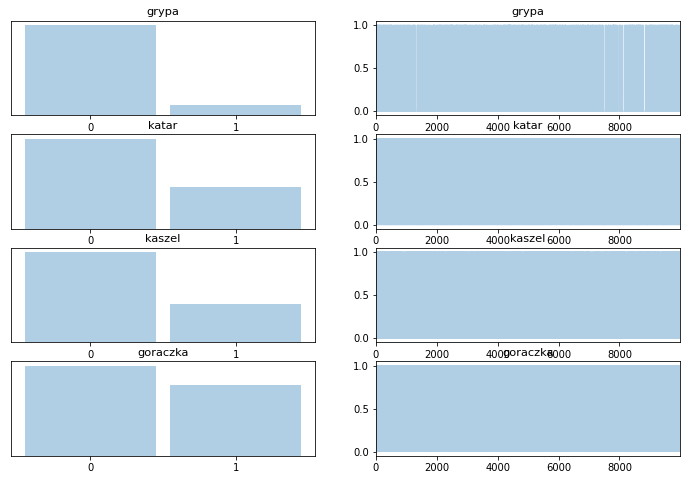

In [9]:
# w module pymc3 dostępne są metody do wygernerowania różnego rodzaju wykresów np.
axs = az.plot_trace(trace, var_names=['grypa', 'katar', 'kaszel', 'goraczka'])

### Obliczanie prawdopodobieństw
Obliczamy interesujące nas prawdopodobieństwa i porównujemy z przykładem, proste zliczanie:

#### Prawdopodobieństawa bezwarunkowe:

In [10]:
# bezwarunkowe prawd. grypy (z założenia powinno być 0.1)
p_grypa = trace.posterior['grypa'].values[0].sum()/len(trace.posterior['grypa'].values[0])
print('p_grypa:', p_grypa)

# bezwarunkowe prawd. kataru (0.32)
p_katar = trace.posterior['katar'].values[0].sum()/len(trace.posterior['katar'].values[0])
print('p_katar:', p_katar)

# bezwarunkowe prawd. kaszlu (0.3)
p_kaszel = trace.posterior['kaszel'].values[0].sum()/len(trace.posterior['kaszel'].values[0])
print('p_kaszel:', p_kaszel)

# bezwarunkowe prawd. goraczki (0.44)
p_goraczka = trace.posterior['goraczka'].values[0].sum()/len(trace.posterior['goraczka'].values[0])
print('p_goraczka:', p_goraczka)

p_grypa: 0.1028
p_katar: 0.3165
p_kaszel: 0.2992
p_goraczka: 0.4408


#### Prawdopodobieństawa warunkowe:

In [11]:
# prawd. grypy pod warunkiem wystąpienia kataru (0.15625)
p_grypa_katar = (trace.posterior['grypa'].values[0]*trace.posterior['katar'].values[0]).sum()/trace.posterior['katar'].values[0].sum()
print('p_grypa_katar:', p_grypa_katar)

# prawd. grypy pod warunkiem wystąpienia kaszlu (0.1)
p_grypa_kaszel = (trace.posterior['grypa'].values[0]*trace.posterior['kaszel'].values[0]).sum()/trace.posterior['kaszel'].values[0].sum()
print('p_grypa_kaszel:', p_grypa_kaszel)

# prawd. grypy pod warunkiem wystąpienia goraczki (0.18182)
p_grypa_goraczka = (trace.posterior['grypa'].values[0]*trace.posterior['goraczka'].values[0]).sum()/trace.posterior['goraczka'].values[0].sum()
print('p_grypa_goraczka:', p_grypa_goraczka)

# prawd. grypy pod warunkiem wystąpienia kataru i goraczki (0.284(09))
p_grypa_katar_goraczka = (trace.posterior['grypa'].values[0]*trace.posterior['katar'].values[0]*trace.posterior['goraczka'].values[0]).sum()/(trace.posterior['katar'].values[0]*trace.posterior['goraczka'].values[0]).sum()
print('p_grypa_katar_goraczka:', p_grypa_katar_goraczka)

p_grypa_katar: 0.1646129541864139
p_grypa_kaszel: 0.10828877005347594
p_grypa_goraczka: 0.18920145190562612
p_grypa_katar_goraczka: 0.28894989704873025


__Jak widać mniej więcej się zgadza. I jak to w symulacjach im dłuższa symulacja tym wyniki powinny być bardziej zbliżone do rzeczywistych.__

## Sieci przekonań
Dla ułatwienia można zbudować graf przedstawiający rzeczywiste zależności między zmiennymi losowymi, i po wyznaczeniu ich prawdopodobieństw warunkowych efektywnie obliczać prawdopodobieństwa innych zdarzeń.

__Siecią przekonań__ (belief network, Bayesian network, probabilistic network) nazywamy następujący graf:
- węzłami sieci są zmienne losowe,
- łuki sieci są skierowane, i łuk $X \to Y$ ma intuicyjne znaczenie: "zmienna $X$ ma bezpośredni wpływ na $Y$",
- każdy węzeł $X$ ma związaną z nim tablicę prawdopodobieństw warunkowych określających wpływ wywierany na $X$ przez jego rodziców (poprzedników w grafie),
- sieć nie może mieć cykli (skierowanych).

Budowa sieci polega na wyznaczeniu jej topologii, oraz prawdopodobieństw warunkowych dla węzłów, dla których istnieją bezpośrednie zależności.

## Przykład 4:
![sprinkler.PNG](http://torus.uck.pk.edu.pl/~amarsz/images/sprinkler.PNG)

### Realizacja w `pymc3`

In [12]:
# źródło:
# https://bugra.github.io/work/notes/2014-05-23/simple-bayesian-network-via-monte-carlo-markov-chain-mcmc-pymc/
# https://gist.github.com/cs224/9a19b4ba2c7511e317be90c32a4d40d7

with pm.Model() as model:
    rain = pm.Bernoulli('rain', 0.2)
    sprinkler_p = pm.Deterministic('sprinkler_p', pm.math.switch(rain, 0.01, 0.40))
    sprinkler = pm.Bernoulli('sprinkler', sprinkler_p)
    grass_wet_p = pm.Deterministic('grass_wet_p', pm.math.switch(rain, pm.math.switch(sprinkler, 0.99, 0.80), pm.math.switch(sprinkler, 0.90, 0.0)))
    grass_wet = pm.Bernoulli('grass_wet', grass_wet_p)

    trace = pm.sample(20000, chains=1, return_inferencedata=True)

Sequential sampling (1 chains in 1 job)
BinaryGibbsMetropolis: [rain, sprinkler, grass_wet]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


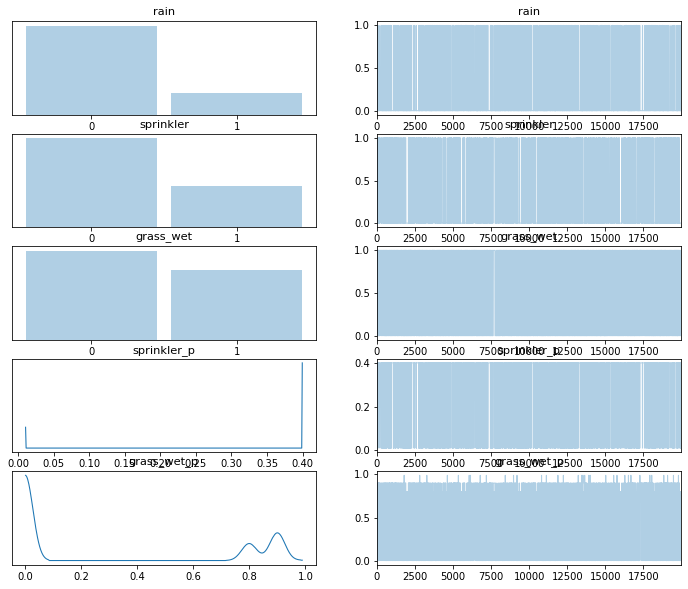

In [13]:
axs = az.plot_trace(trace)

In [14]:
# Jakie jest prawdopodobieństwo, że podało jeśli wiadomo, że trawa jest mokra? 
p_rain_wet = (trace.posterior['rain'].values[0]*trace.posterior['grass_wet'].values[0]).sum()/trace.posterior['grass_wet'].values[0].sum()
print('p_rain_wet:', p_rain_wet)

# Jakie jest prawdopodobieństwo, że włączył się spryskiwacz jeśli wiadomo, że trawa jest mokra? 
p_sprinkler_wet = (trace.posterior['sprinkler'].values[0]*trace.posterior['grass_wet'].values[0]).sum()/trace.posterior['grass_wet'].values[0].sum()
print('p_sprinkler_wet:', p_sprinkler_wet)

# Jakie jest prawdopodobieństwo, że trawa jest mokra jeśli wiadomo, że spryskiwacz się nie włączył oraz nie padało?
p_not_sprinkler_rain_wet = (trace.posterior['grass_wet'].values[0]*np.logical_not(trace.posterior['sprinkler'].values[0])*np.logical_not(trace.posterior['rain'].values[0])).sum()/(np.logical_not(trace.posterior['sprinkler'].values[0])*np.logical_not(trace.posterior['rain'].values[0])).sum()
print('p_not_sprinkler_rain_wet:', p_not_sprinkler_rain_wet)

p_rain_wet: 0.3568667576170987
p_sprinkler_wet: 0.647680763983629
p_not_sprinkler_rain_wet: 0.0


__Przejdź do notatnika z Zadaniami i je wykonaj__

&copy; Katedra Informatyki, Politechnika Krakowska